In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..', '..'))
sys.path.append(src_path)
from transformers import BertTokenizer, AutoTokenizer
from main_regression import RegressionModel, AutomaticScoringDataset as AutomaticScoringDatasetBert
from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F
import joblib
from main_similarity import SiameseModel, AutomaticScoringDataset as AutomaticScoringDatasetSBert
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from scipy.stats import pearsonr
from tabulate import tabulate


In [2]:
config_df = pd.read_csv("config.csv")
epoch_df = pd.read_csv("epoch.csv")
epoch_df.head()
config_df.head()

,config_id,model_type,model_name,pooling_type,epochs,dropout
0,0,sbert,sentence-transformers/distiluse-base-multiling...,mean,13,0.1
1,1,bert,indobenchmark/indobert-lite-base-p2,cls,24,0.3
2,2,mbert,google-bert/bert-base-multilingual-cased,cls,11,0.1


In [3]:
def predict_bert(df_test, config_id, model, tokenizer, trained=True):
    test_data = AutomaticScoringDatasetBert(df_test, tokenizer)
    test_dataloader = DataLoader(test_data, batch_size=16, shuffle=False, generator=torch.Generator().manual_seed(42), num_workers=0)
    
    if trained:
        checkpoint = torch.load(f"../../../models/best_model/spesific/model_{config_id}.pt", map_location='cuda', weights_only=True)
        model.load_state_dict(checkpoint)
    model.eval()
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for batchs in test_dataloader:
            try:
                # move to device
                batchs = {k: v.to('cuda') for k, v in batchs.items()}
                predictions = model(
                    batchs['input_ids'], 
                    batchs['attention_mask'], 
                    batchs['token_type_ids']).squeeze(1)
                # predictions = torch.clamp(predictions, 0, 1)

                all_predictions.extend(predictions.detach().cpu().numpy())
                all_targets.extend(batchs['labels'].detach().cpu().numpy())
            except Exception as e:
                torch.cuda.empty_cache()

    return all_predictions, all_targets

tokenizerSBert = AutoTokenizer.from_pretrained("sentence-transformers/distiluse-base-multilingual-cased-v2")
def compute_cosine_similarity(dataloader, model):
        all_outputs = []
        all_scores = []
        with torch.no_grad():
            for batchs in dataloader:
                batchs = {
                    k: {kk: vv.to("cuda") for kk, vv in v.items()} if isinstance(v, dict) else v.to("cuda")
                    for k, v in batchs.items()
                }
                
                reference_emb = model(batchs['reference_answer']['input_ids'], batchs['reference_answer']['attention_mask'])
                student_emb = model(batchs['student_answer']['input_ids'], batchs['student_answer']['attention_mask'])
                scores = batchs['labels'].float().view(-1)

                ref_embedding = F.normalize(reference_emb, p=2, dim=1)
                student_embedding = F.normalize(student_emb, p=2, dim=1)

                similarity = F.cosine_similarity(ref_embedding, student_embedding, dim=1)
                similarity = torch.clamp(similarity, -1.0, 1.0)

                all_outputs.append(similarity)
                all_scores.append(scores)

        X = torch.cat(all_outputs, dim=0).cpu().numpy()
        y = torch.cat(all_scores, dim=0).cpu().numpy()

        return X, y

def predict_sbert(df_test, config_id, model, trained=True):
    test_data = AutomaticScoringDatasetSBert(df_test, tokenizerSBert)
    test_dataloader = DataLoader(test_data, batch_size=16, shuffle=False, generator=torch.Generator().manual_seed(42), num_workers=0)

    if trained:
        checkpoint = torch.load(f"../../../models/best_model/spesific/model_{config_id}.pt", map_location='cuda', weights_only=True)
        reg_model = joblib.load(f"../../../models/best_model/spesific/reg_{config_id}.pkl")
        model.load_state_dict(checkpoint)
    else:
        # training linear regression model
        df_train = pd.read_csv("../../../../data/clean/spesific/train_indo_balanced.csv")
        train_data = AutomaticScoringDatasetSBert(df_train, tokenizerSBert)
        train_dataloader = DataLoader(train_data, batch_size=16, shuffle=True, generator=torch.Generator().manual_seed(42), num_workers=0)
        model.eval()
        X_train, y_train = compute_cosine_similarity(train_dataloader, model)
        reg_model = LinearRegression()
        reg_model.fit(X_train.reshape(-1, 1), y_train)

    model.eval()
    X_test, y_test = compute_cosine_similarity(test_dataloader, model)
    y_test_pred = reg_model.predict(X_test.reshape(-1, 1))

    return y_test_pred, y_test

def save_predictions(df_test, output_path):
    columns_to_keep = ['question', 'reference_answer', 'answer', 'normalized_score', 'dataset_num']
    columns_to_keep += [col for col in df_test.columns if col.startswith("predicted_score_")]
    df_test = df_test[columns_to_keep]
    df_test.to_csv(output_path, index=False)

In [4]:
import pandas as pd

df_test = pd.read_csv("../../../../data/clean/spesific/test_indo.csv")
is_trained = [True, False]

for row in config_df.itertuples():
    for trained in is_trained:
        if row.model_type == "bert" or row.model_type == "mbert":
            tokenizer = BertTokenizer.from_pretrained(row.model_name)
            model = RegressionModel(row.model_name, pooling_type=row.pooling_type).to('cuda')
            all_predictions, all_targets = predict_bert(df_test, row.config_id, model, tokenizer, trained)
        else:
            model = SiameseModel("sentence-transformers/distiluse-base-multilingual-cased-v2", pooling_type=row.pooling_type).to('cuda')
            all_predictions, all_targets = predict_sbert(df_test, row.config_id, model, trained)

        df_test[f"predicted_score_{row.config_id}_{trained}"] = all_predictions

output_dir = "inference"
os.makedirs(output_dir, exist_ok=True)

save_predictions(df_test, os.path.join(output_dir, "result_compare.csv"))

c:\Users\User\Documents\Code\env\lib\site-packages\transformers\models\distilbert\modeling_distilbert.py:402: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'AlbertTokenizer'. 
The class this function is called from is 'BertTokenizer'.
Some weights of the model checkpoint at indobenchmark/indobert-lite-base-p2 were not used when initializing AlbertModel: ['pooler.bias', 'pooler.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenc


>> Similarity-Based Scoring - fine-tuned
RMSE: 0.0996, Pearson: 0.9285

>> Similarity-Based Scoring
RMSE: 0.1585, Pearson: 0.8251

>> Direct Scoring (IndoBERT) - fine-tuned
RMSE: 0.0826, Pearson: 0.9493

>> Direct Scoring (IndoBERT)
RMSE: 0.6068, Pearson: -0.3051

>> Direct Scoring (mBERT) - fine-tuned
RMSE: 0.0849, Pearson: 0.9477

>> Direct Scoring (mBERT)
RMSE: 0.3923, Pearson: -0.0155


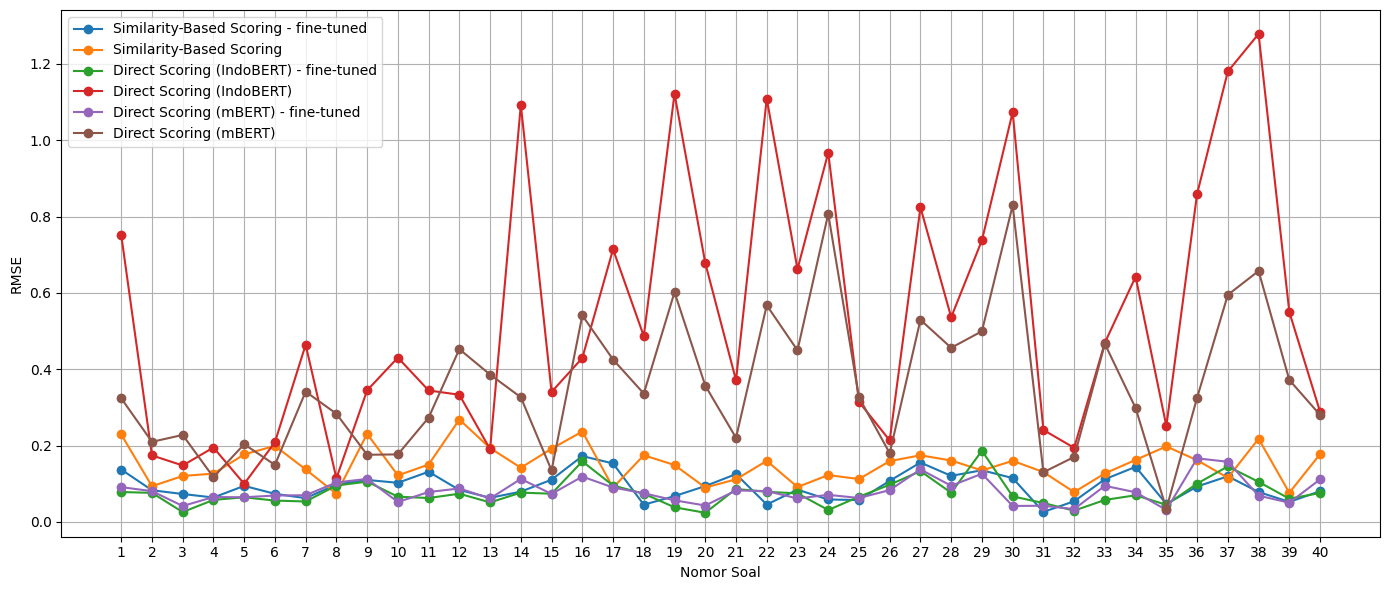

In [7]:
inference_dir = "inference"
csv_files = [f for f in os.listdir(inference_dir) if f.endswith("compare.csv")]

color_palette = plt.get_cmap("tab10") 

label_map = {
    "predicted_score_0_True": "Similarity-Based Scoring - fine-tuned",
    "predicted_score_0_False": "Similarity-Based Scoring",
    "predicted_score_2_True": "Direct Scoring (mBERT) - fine-tuned",
    "predicted_score_2_False": "Direct Scoring (mBERT)",
    "predicted_score_1_True": "Direct Scoring (IndoBERT) - fine-tuned",
    "predicted_score_1_False": "Direct Scoring (IndoBERT)",
}

rmse_per_model = {}
metric_eval_data = {}
model_idx = 0
for file in csv_files:
    file_path = os.path.join(inference_dir, file)
    df = pd.read_csv(file_path)

    true_scores = df['normalized_score'].values
    pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]

    for col in pred_cols:
        pred_scores = df[col].values
        residuals = pred_scores - true_scores

        rmse = root_mean_squared_error(true_scores, pred_scores)
        pearson, _ = pearsonr(true_scores, pred_scores)

        label = label_map.get(col, col) 
        print(f"\n>> {label}")
        print(f"RMSE: {rmse:.4f}, Pearson: {pearson:.4f}")

        metric_eval_data[label] = {
            "RMSE": round(rmse, 4),
            "Pearson": round(pearson, 4)
        }

        rmse_per_soal = df.groupby('dataset_num').apply(lambda x: root_mean_squared_error(x['normalized_score'], x[col]), include_groups=False)
        rmse_per_model[label] = rmse_per_soal
        model_idx += 1

def extract_soal_number(index_series):
    return index_series.astype(str).str.extract(r'(\d+)$').astype(int)[0]

plt.figure(figsize=(14, 6))
for i, label in enumerate(rmse_per_model):
    rmse_series = rmse_per_model[label]
    
    soal_numbers = extract_soal_number(rmse_series.index)
    
    rmse_series.index = soal_numbers
    rmse_series = rmse_series.sort_index()
    
    plt.plot(rmse_series.index, rmse_series.values, marker='o', linestyle='-', label=label)

plt.xlabel("Nomor Soal")
plt.ylabel("RMSE")
plt.grid(True)
plt.legend()
plt.xticks(ticks=sorted(rmse_series.index.unique())) 
plt.tight_layout()
plt.show()

In [8]:
import os
import numpy as np
import pandas as pd

thresholds = [0.1, 0.2]
model_data = []

for file in csv_files:
    df = pd.read_csv(os.path.join(inference_dir, file))
    true_scores = df['normalized_score'].values
    pred_cols = [c for c in df.columns if c.startswith("predicted_score_")]

    for col in pred_cols:
        pred_scores = df[col].values

        abs_residuals = np.abs(pred_scores - true_scores)

        q1 = np.percentile(abs_residuals, 25)
        q3 = np.percentile(abs_residuals, 75)
        iqr = q3 - q1
        upper_bound = q3 + 1.5 * iqr

        outlier_iqr_mask = abs_residuals > upper_bound
        num_outliers_iqr = np.sum(outlier_iqr_mask)

        label = label_map.get(col, col)
        model_data.append({
            "label": label,
            "q1": q1,
            "q3": q3,
            "upper_bound": upper_bound,
            "num_outliers_iqr": num_outliers_iqr,
            "abs_residuals": abs_residuals
        })

outlier_count = {}
for model in sorted(model_data, key=lambda x: x["label"]):
    label = model["label"]
    abs_residuals = model["abs_residuals"]

    print(f"{label}:")
    print(f"  Q1       : {model['q1']:.4f}")
    print(f"  Q3       : {model['q3']:.4f}")
    print(f"  Upper bd : {model['upper_bound']:.4f}")
    print(f"  Outlier (IQR)       : {model['num_outliers_iqr']}")

    outlier_summary = {
        "IQR": model['num_outliers_iqr']
    }

    for t in thresholds:
        num_out = np.sum(abs_residuals > t)
        outlier_summary[f"Fixed {t}"] = num_out
        print(f"  Outlier (Fixed {t}) : {num_out}")

    print()
    outlier_count[label] = outlier_summary


Direct Scoring (IndoBERT):
  Q1       : 0.1492
  Q3       : 0.6904
  Upper bd : 1.5023
  Outlier (IQR)       : 4
  Outlier (Fixed 0.1) : 180
  Outlier (Fixed 0.2) : 148

Direct Scoring (IndoBERT) - fine-tuned:
  Q1       : 0.0164
  Q3       : 0.0856
  Upper bd : 0.1893
  Outlier (IQR)       : 5
  Outlier (Fixed 0.1) : 43
  Outlier (Fixed 0.2) : 4

Direct Scoring (mBERT):
  Q1       : 0.1069
  Q3       : 0.4164
  Upper bd : 0.8806
  Outlier (IQR)       : 5
  Outlier (Fixed 0.1) : 166
  Outlier (Fixed 0.2) : 110

Direct Scoring (mBERT) - fine-tuned:
  Q1       : 0.0265
  Q3       : 0.0878
  Upper bd : 0.1797
  Outlier (IQR)       : 10
  Outlier (Fixed 0.1) : 44
  Outlier (Fixed 0.2) : 9

Similarity-Based Scoring:
  Q1       : 0.0485
  Q3       : 0.1833
  Upper bd : 0.3855
  Outlier (IQR)       : 3
  Outlier (Fixed 0.1) : 119
  Outlier (Fixed 0.2) : 46

Similarity-Based Scoring - fine-tuned:
  Q1       : 0.0268
  Q3       : 0.0917
  Upper bd : 0.1889
  Outlier (IQR)       : 17
  Outlier (